# Spacial Market Segmentation Analysis on Customer Dataset

Based on patterns discovered from the sales data. We have some variables
(indicators) for creation of an index based on variables that you think influence sales patterns. 

Use whichever datasets you find relevant in the folder. 

PROBLEM STATEMENT: Visualize various market segments, and identification of indicator variables that influence sales patterns through time in Kenya. 

In [64]:
#importing packages and classes
import pandas as pd
import numpy as np

# For plotting in python
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

# For working with geographical data
import geopandas as gpd
from geopandas.tools import geocode
from shapely.geometry import Point

# For plotting maps
from xml.etree import ElementTree
import folium
from folium.plugins import MarkerCluster
MarkerCluster()
from branca.element import Figure

# For Regular Expressions
import re


In [162]:
#IMPORTING DATASETS 
df = pd.read_csv('protogas.csv')
df.head() 

,CustomerName,Product A,Product B,Product C,Date,Latitude,Longitude,Sales
0,19,0,39,8,2020-10-28 4:28,-1.186131,36.907541,47
1,43,4,0,0,2020-10-28 4:40,-1.290661,36.728144,4
2,61,0,0,1,2020-10-28 4:50,-1.290410,36.740200,1
3,62,0,1,0,2020-10-28 4:52,-1.185565,36.904532,1
4,71,3,0,0,2020-10-28 4:58,-1.255632,36.722580,4


The Sales Dataset contains 8 columns, customer Name, products, date, location in Lat and Long and Total sales of the 3 products.  

In [163]:
#use a lambda function to apply the geocoder to every row in the DataFrame.

def my_geocoder(row):
    try:
        point = geocode(row, provider='protogas.csv').geometry.iloc[0]
        return pd.Series({'Latitude': point.y, 'Longitude': point.x, 'geometry': point})
    except:
        return None
    
    df[['Latitude', 'Longitude', 'geometry']] = df.apply(lambda x: my_geocoder(x['CustomerName']), axis=1)

print("{}% of Customers were geocoded!".format(
    (1 - sum(np.isnan(df["Latitude"])) / len(df)) * 100))

100.0% of Customers were geocoded!


In [164]:
df.head()

,CustomerName,Product A,Product B,Product C,Date,Latitude,Longitude,Sales
0,19,0,39,8,2020-10-28 4:28,-1.186131,36.907541,47
1,43,4,0,0,2020-10-28 4:40,-1.290661,36.728144,4
2,61,0,0,1,2020-10-28 4:50,-1.290410,36.740200,1
3,62,0,1,0,2020-10-28 4:52,-1.185565,36.904532,1
4,71,3,0,0,2020-10-28 4:58,-1.255632,36.722580,4


I am going to download GeoJSON Dataset of Kenya from (URL: https://data.humdata.org/dataset/e66dbc70-17fe-4230-b9d6-855d192fc05c/resource/51939d78-35aa-4591-9831-11e61e555130/download/kenya.geojson) and import it as kenya_geojson to make our analysis better.  

In [46]:
#Read in our Kenya GeoJSON dataset. 
kenya_geojson=gpd.read_file('https://data.humdata.org/dataset/e66dbc70-17fe-4230-b9d6-855d192fc05c/resource/51939d78-35aa-4591-9831-11e61e555130/download/kenya.geojson')
kenya_geojson.head()


,OBJECTID,ID_,COUNTY_NAM,CONST_CODE,CONSTITUEN,COUNTY_COD,Shape_Leng,Shape_Area,geometry
0,1,5543,NAIROBI,288,KAMUKUNJI,47,1.559787,0.057423,"POLYGON ((36.90458 -1.16071, 36.90809 -1.16157..."
1,2,6634,MOMBASA,3,KISAUNI,1,0.885586,0.023325,"POLYGON ((39.68311 -4.06074, 39.68091 -4.06233..."
2,3,6600,KWALE,10,KINANGO,2,4.284182,0.758266,"POLYGON ((39.32093 -3.57045, 39.31934 -3.57515..."
3,4,6731,KILIFI,13,KALOLENI,3,5.333080,1.025338,"POLYGON ((39.71113 -3.91115, 39.70691 -3.91157..."
4,5,5806,TANA RIVER,19,GALOLE,4,10.280449,3.184213,"POLYGON ((39.02814 -0.00398, 39.03632 -0.00416..."


Kenya GeoJSON Dataset contains geographical data of different constituencies and counties of Kenya in the form of polygons and multi-polygons. A polygon is used for representing a single entity like counties such as Mombasa and multi-polygons are used for representing counties and constituencies which are divided into various parts on a geographic level.

<AxesSubplot:>

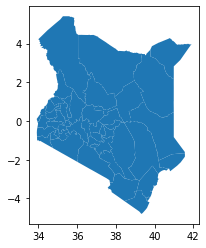

In [26]:
#check if the data is correct by plotting it. Plotting a GeoJSON is very easy using geopandas

kenya_geojson.plot()

# Pre-processing Sales dataset

In this project, our end goal is to Visualize various market segments, and identification of indicator variables that influence sales patterns through time in Kenya. 

For this, we will use the TimeSliderChoropleth plugin of Folium. This is a great plugin that helps in visualizing the changes w.r.t to time. It provides a slider on the top of the choropleth map which you can slide to visualize the change in a quantity over a period of time.

For plotting the map using this plugin, we require two things – the GeoJSON of the place and the data. But here is a catch, it requires the data only in a specific format. The GeoJSON must be string serialized according to the area name, and the data must be given as dictionary in the following format:

In [165]:
data_dict={
    'index_matching_with_area_name_in_geojson':{
        'time_in_milliseconds':{'color':'color_of_region', 'opacity':'opacity_of_region'}
    }
}

In [166]:
#First, we’ll pre-process the sales dataset and then we’ll move to the GeoJSON.
#Let’s start by checking if our dataset contains any null values:

df.isnull().sum()

CustomerName    0
Product A       0
Product B       0
Product C       0
Date            0
Latitude        0
Longitude       0
Sales           0
dtype: int64

In [167]:
#Check for datatypes of our sales data
df.dtypes

CustomerName      int64
Product A         int64
Product B         int64
Product C         int64
Date             object
Latitude        float64
Longitude       float64
Sales             int64
dtype: object

In [88]:
df.describe()

,CustomerName,Product A,Product B,Product C,Latitude,Longitude,Sales
count,50457.000000,50457.000000,50457.000000,50457.000000,50457.000000,50457.000000,50457.000000
mean,226759.705789,0.558872,4.591236,0.452900,-1.269122,36.803633,5.669501
std,160949.597979,2.617621,6.238670,1.234756,0.065545,0.337582,7.100535
min,19.000000,-48.000000,0.000000,0.000000,-2.280770,0.000000,0.000000
25%,66601.000000,0.000000,1.000000,0.000000,-1.290661,36.740093,2.000000
50%,215296.000000,0.000000,3.000000,0.000000,-1.282055,36.754024,4.000000
75%,368086.000000,0.000000,5.000000,0.000000,-1.211727,36.898878,6.000000
max,524441.000000,81.000000,102.000000,44.000000,0.000000,37.171058,110.000000


In [168]:
#Converting date column into DateTime
df['Date']=pd.to_datetime(df['Date'])

In [169]:
df.dtypes

CustomerName             int64
Product A                int64
Product B                int64
Product C                int64
Date            datetime64[ns]
Latitude               float64
Longitude              float64
Sales                    int64
dtype: object

Combining the Latitude and Longitude Columns to Create coordinates which we shall turned into a GeoSeries for visualization purpose.

In [170]:
#Combining 
# Combining
df['coordinates'] = df[['Longitude', 'Latitude']].values.tolist()

# Printing
df.head(3)

,CustomerName,Product A,Product B,Product C,Date,Latitude,Longitude,Sales,coordinates
0,19,0,39,8,2020-10-28 04:28:00,-1.186131,36.907541,47,"[36.9075413, -1.1861307]"
1,43,4,0,0,2020-10-28 04:40:00,-1.290661,36.728144,4,"[36.7281435, -1.2906615]"
2,61,0,0,1,2020-10-28 04:50:00,-1.290410,36.740200,1,"[36.7402, -1.29041]"


In [171]:
# Changing the coordinates into GeoPoint
df['coordinates'] = df['coordinates'].apply(Point)

# Printing
df.head(3)

,CustomerName,Product A,Product B,Product C,Date,Latitude,Longitude,Sales,coordinates
0,19,0,39,8,2020-10-28 04:28:00,-1.186131,36.907541,47,POINT (36.9075413 -1.1861307)
1,43,4,0,0,2020-10-28 04:40:00,-1.290661,36.728144,4,POINT (36.7281435 -1.2906615)
2,61,0,0,1,2020-10-28 04:50:00,-1.290410,36.740200,1,POINT (36.7402 -1.29041)


In [92]:
#Checking type of dataset se have and column coordinates: it is a DataFrame and a Series
type(df['coordinates'])

geopandas.geoseries.GeoSeries

In [172]:
#Converting the DataFrame into a GeoDataFrame and check the types once again: 
#it is a GeoDataFrame and GeoSeries.
df = gpd.GeoDataFrame(df, geometry='coordinates')

# Printing
df.head(3)


,CustomerName,Product A,Product B,Product C,Date,Latitude,Longitude,Sales,coordinates
0,19,0,39,8,2020-10-28 04:28:00,-1.186131,36.907541,47,POINT (36.90754 -1.18613)
1,43,4,0,0,2020-10-28 04:40:00,-1.290661,36.728144,4,POINT (36.72814 -1.29066)
2,61,0,0,1,2020-10-28 04:50:00,-1.290410,36.740200,1,POINT (36.74020 -1.29041)


In [173]:
#Column containing Customer Name is important when plotting - lets assess the unique content or customers
df['CustomerName'].unique()

array([   19,    43,    61, ..., 71736, 71768, 71792], dtype=int64)

In [174]:
df.dtypes

CustomerName             int64
Product A                int64
Product B                int64
Product C                int64
Date            datetime64[ns]
Latitude               float64
Longitude              float64
Sales                    int64
coordinates           geometry
dtype: object

The HeatMapWithTime plugin takes the data in a specific format. It takes the latitudes and longitudes in the form of nested arrays: 

In [177]:
#Creating the nested ARRAY.
from folium.plugins import TimeSliderChoropleth

lat_long_list = []
for i in range(1,25):
    temp=[]
    for index, instance in df[df['Sales'] == i].iterrows():
        temp.append([instance['Latitude'],instance['Longitude']])
    lat_long_list.append(temp)

Creating BASEMAP Of Kenya

In [175]:
#Creating a BASEMAP OF KENYA
from folium.plugins import HeatMapWithTime
fig6=Figure(height=600,width=800)
m1 = folium.Map([-2.00, 39.00], tiles='cartodbpositron', zoom_start=6)
fig6.add_child(m1)

Visualizing the SALES DISTRIBUTION AND MARKET SEGMENTATION Through the Heatmap with Time Plugin.
Plotting through HeatMapWithTime is a three-step process:

1. Import the plugin
2. Create a base map
3. Add the plugin to map

In [176]:
#Adding the Plugging to the MAP. 
HeatMapWithTime(lat_long_list,
                radius=10,
                auto_play=True,
                position='bottomright'
               ).add_to(m1)
m1

In [178]:
#Saving the Map as an HTML Output
m1.save('Sales Segmentation.html')

BASED ON OUR ANALYSIS:-
The sales amounts of the various products;
*I.IMPORTANT MARKET SEGMENTS BY PRODUCT*
1. PRODUCT A experienced and most frequesnt and hightest sales around the Western Parts of Nairobi County (Waithaka, Kawangware, riruta, Kabiria, Githurai, Zimmerman, Kitengela, Athi River, Mlolongo, Rongai, Kiserian, Ruaka areas)

2. PRODUCT B on the other hand experienced and most frequesnt and hightest sales around Naivasha road areas - Riruta and kawangware, Ngong, Elbulbul, Ongata Rongai, Mlolongo, Githurai Areas - Zimmerman, KWEST, South C and B. 

3. PRODUCT C experienced and most frequesnt and hightest sales around Githurai areas and ZImmerman, Kinyanjui road of riruta areas, Mlolongo, Kiserian, Rongai, Ngong, Thome, Ngara 

*II. DEFINATION OF MICROMARKETS*
1. These micro-markets seems to be defined around densely populated settlements within Nairobi County Region.  
2. The markets also seemed to be influenced by time - duting the day, when people are most active in the market places or going about their business is when most sales is recorded as seen on the heatmaps. 
3. Income levels also seem to influence the sales distribution among the products.  

*III. MICROMARKETS YIELDING THE BEST OPPORTUNTIES FOR REVENUE GROWTH*
1. GITHURAI + KASARANI + Zimmerman regions 
2. Kawangware + Kangemi + Riruta + Lenana regions
3. Ngong Region
4. Ongata Rongai Region
5. Kiserian Region. 
6. Syokimau + Mlolongo Regions 
7. Kitengela Region
8. Langata + Kibera Regions. 

*IV. WHERE TO FIND MOST OF THESE POTENTIAL MARKETS* 
1. Focus on densely populated settlements
2. Low income regions our of Nairobi County. 
3. Mombasa, Tana River and Kilifi Counties have their demographics clustered and low incomed as well. 
4. Western Kenya has a dense population as well - with low income. 